## Data Cleaning (keeping only images with faces and more than 1 eyes)

In [33]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

### Importing Image

In [34]:
img = cv2.imread(r"D:\VS Code\marvel_celebrity_image_classification\model\test_images\18.jpg")
img.shape

(1677, 1677, 3)

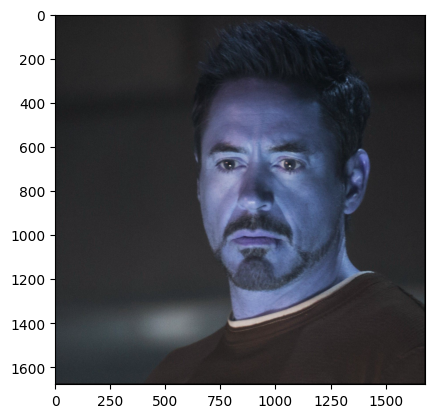

In [35]:
plt.imshow(img)

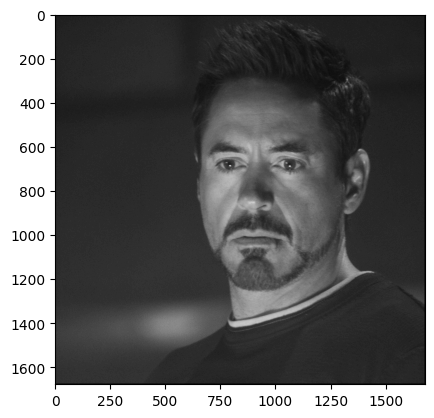

In [36]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

### Detecting Position of Face in Images

In [37]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade= cv2.CascadeClassifier('D:\\VS Code\\marvel_celebrity_image_classification\\model\\opencv\\haarcascades\\haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray,1.3,5)
faces

#Returned Values of faces (x,y,width & height) from where face starts forming a rectangle

array([[498, 317, 852, 852]], dtype=int32)

In [38]:
(x,y,w,h) = faces[0]
print(x,y,w,h)

498 317 852 852


### Plotting Red Rectangle around face in Image

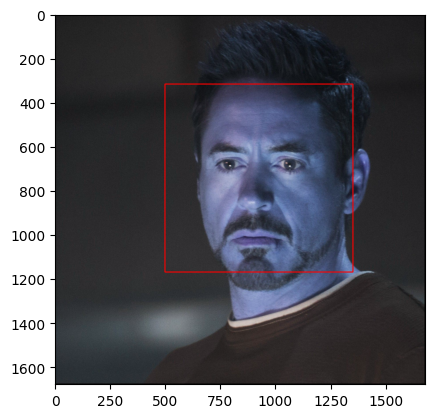

In [39]:
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),4)
plt.imshow(face_img)

cropped_img = img[y:y+h, x:x+w]
#plt.imshow(cropped_img)

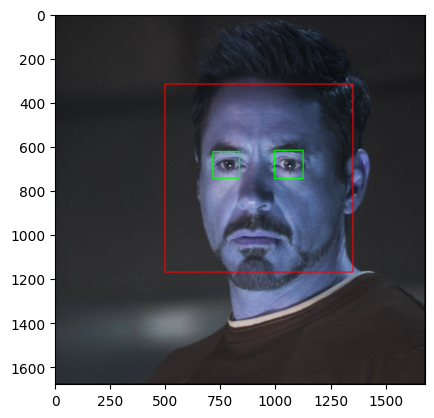

In [40]:
eyes = eye_cascade.detectMultiScale(gray,1.3,5)
for (ex,ey,ew,eh) in eyes:
    eye_img = cv2.rectangle(img,(ex,ey),(ex+ew,ey+eh),(0,255,0),3)
    
plt.imshow(eye_img)
#plt.imshow(cropped_img, cmap='gray')

### Funtion to return cropped Image

In [41]:
def crop_img(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    # Check if one or more faces are detected
    if len(faces) >= 1:
        x, y, w, h = faces[0]
        cropped_gray_face = gray[y:y+h, x:x+w]
        cropped_color_face = img[y:y+h, x:x+w]
        # Detect eyes within the cropped face
        eyes = eye_cascade.detectMultiScale(cropped_gray_face)
        # Check if exactly two eyes are detected
        if len(eyes) >= 2:
            return cropped_color_face      
       
#for (ex,ey,ew,eh) in eyes:
    #    eye_img = cv2.rectangle(img,(ex,ey),(ex+ew,ey+eh),(0,255,0),3)

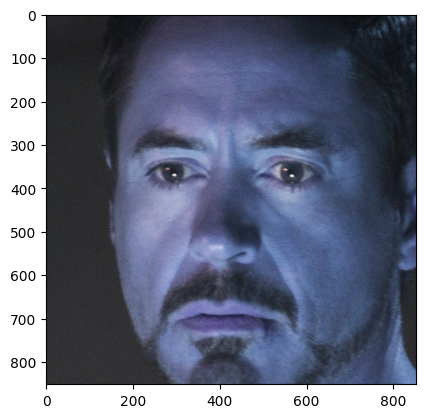

In [42]:
cropped_img = crop_img(r"D:\VS Code\marvel_celebrity_image_classification\model\test_images\18.jpg")    
plt.imshow(cropped_img)
#print(cropped_img)

### Creating directories and storing path of all datasets

In [43]:
# Storing paths in variables
path_to_data = "./Dataset/"
path_to_cr_data = "./Dataset/cropped/"

In [44]:
#Storing path of individual persons images
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

img_dirs

['./Dataset/Captain_America',
 './Dataset/Spider_Man-Toby_Maguire',
 './Dataset/Thor',
 './Dataset/Tony_Stark',
 './Dataset/Wolverine']

In [45]:
# If cropped folder exists remove it and create new folder, else create new folder

import shutil
if os.path.exists(path_to_cr_data):
    shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

### Storing cropped Images in Directories

In [46]:
#Celebrity name using directories
#Storing cropped Images into new directories
cropped_img_dirs = []
celebrity_file_names_dict = {}

for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    print(celebrity_name)

    celebrity_file_names_dict[celebrity_name] = []

    for entry in os.scandir(img_dir):
        cropped_color_face = crop_img(entry.path)
        if cropped_color_face is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_img_dirs.append(cropped_folder)
                print("Generating Cropped Images in folder:", cropped_folder)
            
            #Storing cropped images in its respective folder
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name

            cv2.imwrite(cropped_file_path, cropped_color_face)
            #Storing name of all image file paths in dictionary
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count+=1


#After doing few Manual Cleaning Data Cleaning is Done

Captain_America
Generating Cropped Images in folder: ./Dataset/cropped/Captain_America
Spider_Man-Toby_Maguire
Generating Cropped Images in folder: ./Dataset/cropped/Spider_Man-Toby_Maguire
Thor
Generating Cropped Images in folder: ./Dataset/cropped/Thor
Tony_Stark
Generating Cropped Images in folder: ./Dataset/cropped/Tony_Stark
Wolverine
Generating Cropped Images in folder: ./Dataset/cropped/Wolverine


## Feature Engineering using Wavelet Transformation

In [47]:
#Function for Wavelet transformation for feature Exctraction
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

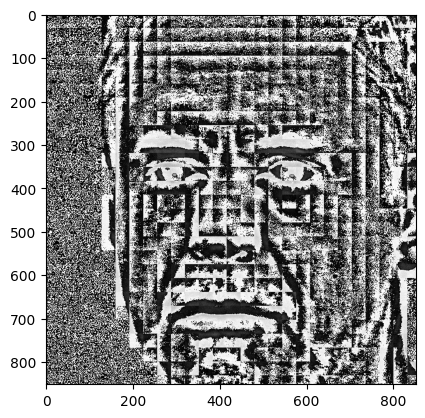

In [48]:
im_har = w2d(cropped_img,'db1',5)
plt.imshow(im_har, cmap='gray')

### Using Stacked Raw (Cropped) and Wavelet Transformed Image for Input

In [62]:
# Updating Dictionary removing paths of deleted images

celebrity_file_names_dict = {}
for img_dir in cropped_img_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list

celebrity_file_names_dict

{'Captain_America': ['./Dataset/cropped/Captain_America\\Captain_America1.png',
  './Dataset/cropped/Captain_America\\Captain_America10.png',
  './Dataset/cropped/Captain_America\\Captain_America11.png',
  './Dataset/cropped/Captain_America\\Captain_America13.png',
  './Dataset/cropped/Captain_America\\Captain_America14.png',
  './Dataset/cropped/Captain_America\\Captain_America15.png',
  './Dataset/cropped/Captain_America\\Captain_America16.png',
  './Dataset/cropped/Captain_America\\Captain_America17.png',
  './Dataset/cropped/Captain_America\\Captain_America18.png',
  './Dataset/cropped/Captain_America\\Captain_America19.png',
  './Dataset/cropped/Captain_America\\Captain_America2.png',
  './Dataset/cropped/Captain_America\\Captain_America20.png',
  './Dataset/cropped/Captain_America\\Captain_America21.png',
  './Dataset/cropped/Captain_America\\Captain_America23.png',
  './Dataset/cropped/Captain_America\\Captain_America24.png',
  './Dataset/cropped/Captain_America\\Captain_America

### Labelling(Numeric Values) Names of Celebrities 

In [63]:
class_dict = {}
count = 0

for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count+= 1

class_dict


{'Captain_America': 0,
 'Spider_Man-Toby_Maguire': 1,
 'Thor': 2,
 'Tony_Stark': 3,
 'Wolverine': 4}

### Creating Input and Output Labels

In [65]:
#Iterating through each image using Dictionary of  celebrity Names and their path

X,y= [],[]

for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:

        img = cv2.imread(training_image)
        # Skip those files which are manually deleted and return None 
        #if img is None:
        #    continue
        scaled_raw_img = cv2.resize(img, (32,32))
        
        img_har = w2d(img, 'db1', 5)
        scaled_img_har = cv2.resize(img_har, (32,32))
        
        #Vertically Stacking (*3 is RGB color)
        combined_img = np.vstack((scaled_raw_img.reshape(32*32*3,1), scaled_img_har.reshape(32*32,1)))

        X.append(combined_img)
        y.append(class_dict[celebrity_name])


In [66]:
# 32*32*3 + 32*32 (x*y*RGB)
len(X[0])

4096

In [67]:
#Reshaping to float to avoid warnings in sklearn
X= np.array(X).reshape(len(X),4096).astype(float)
X.shape

(170, 4096)

In [68]:
X[0]

array([ 69.,  98., 107., ..., 248.,  55., 253.])

## Training the Model

In [75]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report